In [6]:
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
names = open('names.txt','r').read().splitlines()
chars = sorted(list(set((''.join(names)))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}
vocab_size = len(stoi)

In [8]:
def train_dev_test_data(names, block_size=3, n=None):
    X, y = [], []
    for name in names[:n]:
        context = [0] * block_size
        for char in name + '.':
            i = stoi[char]
            X.append(context)
            y.append(i)
            if n is not None and n < 10:
                print(''.join(itos[j] for j in context), '->', itos[i])
            context = context[1:] + [i]
    
    zipped = list(zip(X, y))
    random.shuffle(zipped)
    X, y = zip(*zipped)
    
    n_dev = int(0.8 * len(X))
    n_test = int(0.9 * len(X))
    
    X_train = torch.tensor(X[:n_dev])
    y_train = torch.tensor(y[:n_dev])
    
    X_dev = torch.tensor(X[n_dev:n_test])
    y_dev = torch.tensor(y[n_dev:n_test])
    
    X_test = torch.tensor(X[n_test:])
    y_test = torch.tensor(y[n_test:])
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [97]:
dim_embed = 10
block_size = 3
n_hid = 200
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, block_size=block_size)
C = torch.randn(vocab_size, dim_embed)
W1 = torch.randn(dim_embed * block_size, n_hid) #* (5 / 3) / ((dim_embed * block_size) ** 0.5) # gain to modify activation std and reduce tanh saturation
b1 = torch.randn(n_hid)
W2 = torch.randn(n_hid, vocab_size) #* 0.01 # ensure softmax gives uniform distribution output
b2 = torch.randn(vocab_size) #* 0
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True
lossi = []

      0/ 200000: 29.2036


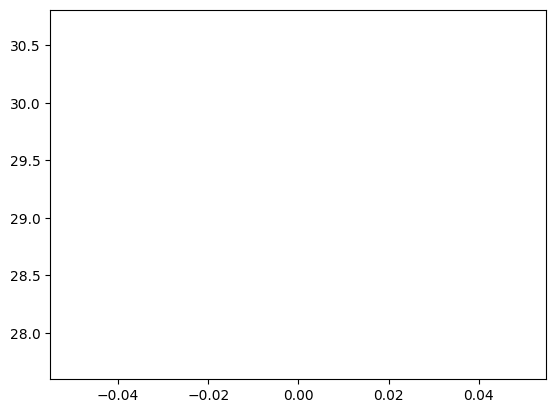

In [98]:
a = 0.1 # from plotting loss against different a and taking minimum
sz = 32
epochs = 200000

for e in range(epochs):
    # minibatch
    rows = torch.randint(0, X_train.shape[0], (sz, ))
    
    # forward pass
    emb = C[X_train[rows]]
    h = torch.tanh(emb.view(-1, dim_embed * block_size) @ W1 + b1) # 6 = block_size * dim(embedding space), basically want to get the embedding per input all on one row
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[rows])

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # gradient descent
    for p in params:
        p.data -= a * p.grad if e < epochs / 2 else 0.1 * a * p.grad

    lossi.append(loss.item())

    if e % 10000 == 0:
        print(f'{e:7d}/{epochs:7d}: {loss.item():.4f}')
    break
    
plt.plot(lossi);

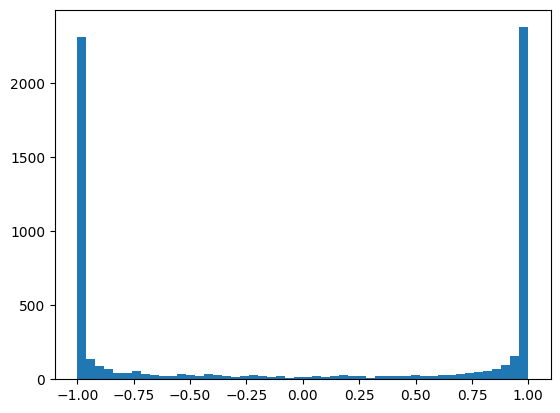

In [99]:
plt.hist(h.view(-1).tolist(), bins=50);

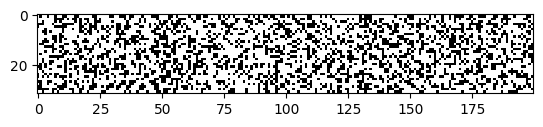

In [100]:
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [101]:
@torch.no_grad()
def compute_loss(split):
    X, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_dev)
    }[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, dim_embed * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

print(f'Training loss: {compute_loss('train'):.4f}')
print(f'Dev loss: {compute_loss('dev'):.4f}')

Training loss: 24.9205
Dev loss: 24.8938


Baseline:
- Training loss: 2.1165
- Dev loss: 2.1600

Uniform softmax:
- Training loss: 2.0666
- Dev loss: 2.1329

Unsaturated tanh:
- Training loss: 2.0428
- Dev loss: 2.1130

In [74]:
def make_name(k):
    g = torch.Generator().manual_seed(2147483647 + k)
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        i = torch.multinomial(p, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        out.append(i)
        if i == 0:
            break

    return ''.join([itos[i] for i in out])

for k in range(10):
    print(make_name(k))

junide.
camrielor.
lylinna.
alianney.
jhyla.
bari.
amine.
kylynn.
reiva.
kelleentella.
